# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [1]:
import pathlib

import joblib
import keras_tuner as kt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Activation, BatchNormalization, Dense,
                                     Dropout, Input)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam

tf.config.optimizer.set_jit(True)
mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

ModuleNotFoundError: No module named 'joblib'

### Plotting Functions 

In [ ]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'.',markersize = 7,color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,markersize = 5, color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc [W]':
        Aux = np.linspace(0,80)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        #plt.text(140, 180, '$+ 5 \%$', fontsize=12)
        #plt.text(150, 120, '$- 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - ANN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Numerical Solution')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(23, 17, '$- 5 \%$', fontsize=12)
        plt.text(19, 28, '$+ 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,mag}$ [W] - ANN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,mag}$ [W] - Numerical Solution')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [ ]:
Inputs = pd.read_excel('Data/Data_AMR_Exp.xlsx',index_col = 0) # Input Data
X = Inputs[Inputs.columns[:-4]]
y = Inputs[['Qc [W]']]

### Train-Test Split

In [ ]:
Qc_min = 1

In [ ]:
X = X[(y['Qc [W]'] > Qc_min) & (X['Test'] != 'MCR')]
y = y[(y['Qc [W]'] > Qc_min) & (X['Test'] != 'MCR')]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    stratify = X['Test'],
                                                    random_state = 42)
X_train = X_train.drop(['Test'],axis = 1)
X_test = X_test.drop(['Test'],axis = 1)

### Scaling the Features

In [ ]:
sc = joblib.load('Models/AMR_Scaler.pkl')
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [ ]:
joblib.dump(sc, 'Models/AMR_Scaler.pkl') 

['Models/AMR_Scaler.pkl']

### Building the Model

In [ ]:
def Build(hp):
    
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())

    #Kernel Initialization
    initializer = tf.keras.initializers.HeNormal()

    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 5)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 2001, step=20),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu','tanh']),
                                        kernel_initializer = initializer
                                        )
        )
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                            loss="mean_squared_error",
                            metrics = ['accuracy']
                            )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [ ]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1, 501, step=5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [ ]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory= 'KT_Dir',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 #callbacks=[EarlyStopping('val_loss', patience=5)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5', include_optimizer=False)
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN', include_optimizer=False)
    best_model.save_weights('Models/'+Obj+'/'+ Obj +'_weights.h5')
    #joblib.dump(best_model, 'Models/'+Obj+'/'+ Obj +'_NN.pkl')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

### Defining a Test Function

In [ ]:
def Test(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    Model.summary()
    for i, layer in enumerate (Model.layers):
        print (i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
            
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Model.predict(Scal.transform(X_train)))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Model.predict(Scal.transform(X_test))))) 

    # Plotting the Results
    plot_results(y_train[Obj], Model.predict(Scal.transform(X_train)), y_test[Obj], Model.predict(Scal.transform(X_test)), Obj) 

In [ ]:
def Test_lite(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    for i, layer in enumerate (Model.layers):
        print (i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
    converter = tf.lite.TFLiteConverter.from_keras_model(Model)
    tflite_model = converter.convert()
    tflite_models_dir = pathlib.Path("/")
    tflite_models_dir.mkdir(exist_ok=True, parents=True)
    tflite_model_file = tflite_models_dir/"mnist_model.tflite"
    tflite_model_file.write_bytes(tflite_model)
    
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    Train_Lite = []
    for i in range(np.shape(X_train)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_train)[i].reshape(-1,1).T)
        interpreter.invoke()
        Train_Lite.append(interpreter.get_tensor(output_index)[0][0])
        
    Test_Lite = []
    for i in range(np.shape(X_test)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_test)[i].reshape(-1,1).T)
        interpreter.invoke()
        Test_Lite.append(interpreter.get_tensor(output_index)[0][0])
    
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Train_Lite)))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Test_Lite)))    
    
    # Plotting the Results
    plot_results(y_train[Obj], Train_Lite, y_test[Obj], Test_Lite, Obj) 

### Training the Models

In [ ]:
NeuNet(X_train,y_train,1000,'Qc [W]')

Trial 30 Complete [00h 00m 58s]
val_loss: 9.218450546264648

Best val_loss So Far: 7.511434555053711
Total elapsed time: 00h 14m 18s



Search: Running Trial #31

Hyperparameter    |Value             |Best Value So Far 
layers            |2                 |4                 
batch_size        |41                |26                
units_0           |921               |241               
act_0             |selu              |selu              
units_1           |1481              |1201              
act_1             |tanh              |selu              
units_2           |521               |1701              
act_2             |tanh              |relu              
units_3           |781               |1501              
act_3             |selu              |tanh              
units_4           |1521              |1341              
act_4             |selu              |sigmoid           
tuner/epochs      |334               |334               
tuner/initial_e...|112               |112               
tuner/bracket     |6                 |6                 
tuner/round       |5                 |5                 
tun

UnknownError: Failed to rename: KT_Dir\KT_Hyperband_Qc [W]\trial_51005d7cafa79127285e2e448a0bb23e\checkpoints\epoch_0\checkpoint_temp_d77d0030ff16408eaf6838c1e4fa7616/part-00000-of-00001.data-00000-of-00001 to: KT_Dir\KT_Hyperband_Qc [W]\trial_51005d7cafa79127285e2e448a0bb23e\checkpoints\epoch_0\checkpoint.data-00000-of-00001 : Acesso negado.
; Input/output error [Op:MergeV2Checkpoints]

### Testing the Models

### Reading the Input Parameteres 

In [ ]:
Inputs = pd.read_excel('Data/Data_AMR_Exp.xlsx',index_col = 0) # Input Data
X = Inputs[Inputs.columns[:-4]]
y = Inputs[['Qc [W]']]

### Train-Test Split

In [ ]:
X = X[(y['Qc [W]'] > Qc_min) & (X['Test'] != 'MCR')]
y = y[(y['Qc [W]'] > Qc_min) & (X['Test'] != 'MCR')]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    stratify = X['Test'],
                                                    random_state = 42)
X_train = X_train.drop(['Test'],axis = 1)
X_test = X_test.drop(['Test'],axis = 1)

### Scaling the Features

In [ ]:
Scaller = joblib.load('Models/AMR_Scaler.pkl')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 31)                124       
_________________________________________________________________
dense (Dense)                (None, 281)               8992      
_________________________________________________________________
batch_normalization_1 (Batch (None, 281)               1124      
_________________________________________________________________
dense_1 (Dense)              (None, 606)               170892    
_________________________________________________________________
batch_normalization_2 (Batch (None, 606)               2424      
_________________________________________________________________
dense_2 (Dense)              (None, 391)               237337    
_________________________________________________________________
batch_normalization_3 (Batch (None, 391)               1

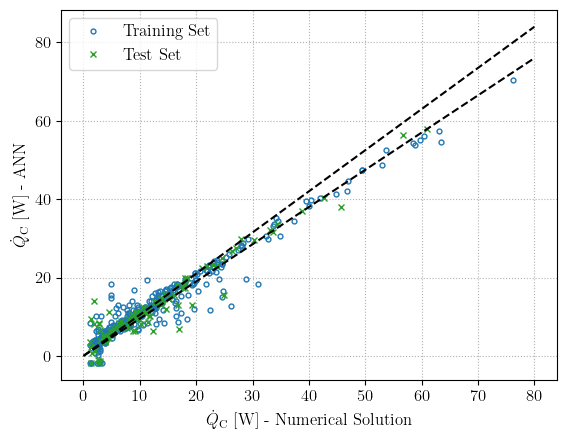

In [ ]:
Test(X_train,y_train,'Qc [W]',Scaller)

In [ ]:
Test_lite(X_train,y_train,'Qc [W]',Scaller)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 31)               124       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 991)               31712     
                                                                 
 batch_normalization_1 (Batc  (None, 991)              3964      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 536)               531712    
                                                                 
 batch_normalization_2 (Batc  (None, 536)              2144      
 hNormalization)                                                 
                                                        

ValueError: Cannot set tensor: Got value of type FLOAT64 but expected type FLOAT32 for input 0, name: serving_default_batch_normalization_input:0 